# Data Pre-processing & Feature Selection

In [ ]:
###########################################################################
#
#  Copyright 2021 Google Inc.
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      https://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
# This solution, including any related sample code or data, is made available
# on an “as is,” “as available,” and “with all faults” basis, solely for
# illustrative purposes, and without warranty or representation of any kind.
# This solution is experimental, unsupported and provided solely for your
# convenience. Your use of it is subject to your agreements with Google, as
# applicable, and may constitute a beta feature as defined under those
# agreements.  To the extent that you make any data available to Google in
# connection with your use of the solution, you represent and warrant that you
# have all necessary and appropriate rights, consents and permissions to permit
# Google to use and process that data.  By using any portion of this solution,
# you acknowledge, assume and accept all risks, known and unknown, associated
# with its usage, including with respect to your deployment of any portion of
# this solution in your systems, or usage in connection with your business,
# if at all.
###########################################################################

## 0) Dependencies

In [103]:
################################################################################
######################### CHANGE BQ PROJECT NAME BELOW #########################
################################################################################

project_name = 'OnStar_RBA_0702' #add proj name
## Testing Changing directory

In [156]:
# Google credentials authentication libraries
# Work in Google Colab
from google.colab import auth
auth.authenticate_user()

import sys
import warnings

# data processing libraries
import numpy as np

from numpy.core.numeric import NaN
import datetime
import pandas as pd
import pandas_gbq

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier

# modeling and metrics
from scipy.optimize import least_squares
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm


import itertools
#from scipy.stats.stats import pearsonr
# scipy.stats.stats deprecated, update with new code:
from scipy.stats import pearsonr

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5] #change size of plot
import seaborn as sns
import plotly.express as px

# BigQuery Magics
'''
BigQuery magics are used to run BigQuery SQL queries in a python environment.
These queries can also be run in the BigQuery UI
'''

from google.cloud import bigquery
from google.cloud.bigquery import magics

magics.context.project = project_name

client = bigquery.Client(project=magics.context.project)

In [4]:
# For Feature Selection
!pip install boruta #boruta for feature selection
from boruta import BorutaPy

## 07.02 Upgrade package
#pip install --upgrade boruta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.6 MB/s eta 0:00:00


## 1) Import dataset
#####Only one of the following sections should be executed, either import from CSV, BigQuery, or Google Sheets.

##Import Original Data from BigQuery (Option #1)

In [ ]:
# #@title
# auth.authenticate_user()
# bigquery.USE_LEGACY_SQL = False

# magics.context.project = project_name
# client = bigquery.Client(project=magics.context.project)
# %load_ext google.cloud.bigquery
# project_id = project_name
# dataset_name = '' #@param {type:"string"}
# table_name = '' #@param {type:"string"}
# query = 'select * from `' +  dataset_name + '.'+ table_name + '`'
# df = pd.io.gbq.read_gbq(query, project_id=project_id, dialect='standard')
# df.head()

## Upload Original Data CSV (Option #2)

In [104]:
#update file name
file_name = 'https://raw.githubusercontent.com/zzWIInTer/zz_onstar_rba/master/output_Unattributed_0702.csv'

#https://github.com/zzWIInTer/zz_onstar_rba/blob/master/output_Unattributed_0702.csv

df = pd.read_csv(file_name)
df.fillna(0, inplace=True)

df.head()

,Date,A_OC_GOOGLE_SHOPPING,C_DIV_BUY_CONNECTED,C_DIV_BUY_ESSENTIALS,C_DIV_BUY_PREMIUM,C_DIV_BUY_SS,C_DIV_CONN_DATA,C_DIV_CONN_REMOTE,C_DIV_CONN_TRY,C_DIV_GETNOW_CONN,...,DIV_PLANPAGE_HOME,DIV_WYG_PP,OC_APP_Access,OC_PAGE_ESS,OC_PAGE_PREF,OC_PAGE_PREFPL,OC_PAGE_PREM,SC_BUYNOW,SC_HOMEPAGE,SC_SHOPNOW
0,10/13/2023,729,28,21,20,19,12,11,8,110,...,767,3013,388,680,156,288,1350,0,18,1
1,10/14/2023,936,30,7,23,14,18,7,9,94,...,719,2681,374,575,138,283,1166,0,15,2
2,10/15/2023,787,20,5,7,8,8,3,11,66,...,517,2442,366,385,105,249,960,0,15,0
3,10/16/2023,1030,29,10,23,16,10,8,4,74,...,722,2907,472,728,210,378,1425,2,16,0
4,10/17/2023,950,26,11,22,8,11,6,5,85,...,790,3167,418,612,209,310,1258,0,10,0


## Import Data from Sheets (Option #3)

In [ ]:
# import gspread
# from google.auth import default
# creds, _ = default()
# gc = gspread.authorize(creds)
# auth.authenticate_user()
# sheet_name = '' #@param {type:"string"}
# worksheet = gc.open(sheet_name).sheet1

# # get_all_values gives a list of rows.
# rows = worksheet.get_all_values()

# # Convert to a DataFrame and render.
# original_data_import = pd.DataFrame.from_records(rows)
# df = original_data_import.rename(
#     columns=original_data_import.iloc[0]).drop(
#         original_data_import.index[0]).reset_index(drop=True).astype('float')
# df.head()

The first step is to remove variables that won't be used in the model. In this example, we remove columns like geo which is consistent across the dataset and aggregated media such as total clicks across DSPs.


In [ ]:
#df.drop(columns = ['geo','x1','x2','x8','x18','x19','x20','x21','x22','x23','x24','x25'], inplace = True)

In [105]:
len(df.columns)

39

In [106]:
df.describe()

,A_OC_GOOGLE_SHOPPING,C_DIV_BUY_CONNECTED,C_DIV_BUY_ESSENTIALS,C_DIV_BUY_PREMIUM,C_DIV_BUY_SS,C_DIV_CONN_DATA,C_DIV_CONN_REMOTE,C_DIV_CONN_TRY,C_DIV_GETNOW_CONN,C_DIV_GETNOW_ESS,...,DIV_PLANPAGE_HOME,DIV_WYG_PP,OC_APP_Access,OC_PAGE_ESS,OC_PAGE_PREF,OC_PAGE_PREFPL,OC_PAGE_PREM,SC_BUYNOW,SC_HOMEPAGE,SC_SHOPNOW
count,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,...,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000
mean,1081.584475,53.803653,24.155251,39.488584,21.095890,14.009132,10.146119,9.347032,91.260274,24.392694,...,874.707763,2769.579909,417.593607,2029.972603,217.251142,492.264840,1439.858447,1.091324,9.273973,1.328767
std,563.675923,20.670033,9.192319,16.842323,8.502829,4.807287,5.126529,3.273206,23.402949,21.933200,...,192.744510,512.028469,71.384950,4140.619730,75.071195,160.185252,392.876002,1.219440,9.160536,1.185402
min,0.000000,15.000000,5.000000,7.000000,3.000000,4.000000,2.000000,3.000000,46.000000,5.000000,...,434.000000,1511.000000,237.000000,385.000000,74.000000,194.000000,844.000000,0.000000,0.000000,0.000000
25%,781.500000,36.500000,18.000000,25.500000,14.000000,10.500000,7.000000,7.000000,75.000000,15.000000,...,742.000000,2439.500000,367.000000,645.000000,158.500000,365.000000,1203.000000,0.000000,0.000000,0.000000
50%,972.000000,53.000000,23.000000,37.000000,21.000000,14.000000,9.000000,9.000000,88.000000,19.000000,...,854.000000,2800.000000,406.000000,796.000000,208.000000,477.000000,1378.000000,1.000000,11.000000,1.000000
75%,1209.500000,68.500000,31.000000,52.500000,27.000000,17.000000,12.000000,11.000000,103.500000,25.000000,...,985.500000,3048.000000,461.500000,1291.500000,265.500000,624.500000,1594.500000,2.000000,16.000000,2.000000
max,4317.000000,116.000000,51.000000,80.000000,48.000000,36.000000,34.000000,23.000000,233.000000,150.000000,...,1385.000000,4774.000000,624.000000,28132.000000,437.000000,913.000000,4470.000000,7.000000,42.000000,6.000000


In [107]:
#Set the date as index
date_col = "Date" #@param {type:"string"}
df = df.sort_values(date_col).set_index(date_col)

In [108]:
'''If using daily data in the final model, set to True.
If data is already at the weekly level OR if you'd like to
roll daily data up to weekly level, leave as false
'''
is_daily_data = True #@param {type:"boolean"}

Option to aggregate daily data to weekly data

In [110]:
# Uncomment and run code below if you'd like to roll daily data up to weekly level.
'''
if is_daily_data == False:
  df = df.resample('7D').sum()
  '''

"\nif is_daily_data == False:\n  df = df.resample('7D').sum()\n  "

In [109]:
df.head()

,A_OC_GOOGLE_SHOPPING,C_DIV_BUY_CONNECTED,C_DIV_BUY_ESSENTIALS,C_DIV_BUY_PREMIUM,C_DIV_BUY_SS,C_DIV_CONN_DATA,C_DIV_CONN_REMOTE,C_DIV_CONN_TRY,C_DIV_GETNOW_CONN,C_DIV_GETNOW_ESS,...,DIV_PLANPAGE_HOME,DIV_WYG_PP,OC_APP_Access,OC_PAGE_ESS,OC_PAGE_PREF,OC_PAGE_PREFPL,OC_PAGE_PREM,SC_BUYNOW,SC_HOMEPAGE,SC_SHOPNOW
Date,,,,,,,,,,,,,,,,,,,,,
1/1/2024,354,30,9,17,10,12,4,4,73,13,...,580,1979,255,544,84,296,944,1,6,1
1/10/2024,1134,56,28,44,23,10,20,7,71,23,...,975,3617,379,748,134,399,1378,3,19,1
1/11/2024,1293,44,33,38,31,15,16,9,80,35,...,948,3326,473,843,176,427,1527,1,24,1
1/12/2024,1374,38,23,46,19,10,16,7,97,25,...,944,3368,429,741,170,398,1507,1,19,1
1/13/2024,1455,46,20,28,8,15,13,9,74,25,...,890,2951,490,838,172,388,1587,1,9,1


## 2) Data Cleaning

### 2.1) Check for missing data and impute

Check the amount of of missing values (% of total column) in the data and sort by
highest to lowest.

In [111]:
missing_values = 100*df.isnull().sum()/len(df)
missing_values.sort_values(ascending = False)

A_OC_GOOGLE_SHOPPING     0.0
DIV_PLANPAGE_HOME        0.0
DIV_GMOC_SHOP_SS         0.0
DIV_PKG_CONN_SERVICES    0.0
DIV_PKG_HDStreaming      0.0
DIV_PKG_SS_CRASH         0.0
DIV_PKG_SS_ROADSIDE      0.0
DIV_PLANPAGE_CONN        0.0
DIV_PLANPAGE_ESS         0.0
DIV_WYG_PP               0.0
C_DIV_BUY_CONNECTED      0.0
OC_APP_Access            0.0
OC_PAGE_ESS              0.0
OC_PAGE_PREF             0.0
OC_PAGE_PREFPL           0.0
OC_PAGE_PREM             0.0
SC_BUYNOW                0.0
SC_HOMEPAGE              0.0
DIV_GMOC_SHOP_REMOTE     0.0
DIV_GMOC_SHOP_ESS        0.0
C_PP_PKG_SS              0.0
C_PP_PKG_SC              0.0
C_DIV_BUY_ESSENTIALS     0.0
C_DIV_BUY_PREMIUM        0.0
C_DIV_BUY_SS             0.0
C_DIV_CONN_DATA          0.0
C_DIV_CONN_REMOTE        0.0
C_DIV_CONN_TRY           0.0
C_DIV_GETNOW_CONN        0.0
C_DIV_GETNOW_ESS         0.0
C_DIV_GETNOW_PREM        0.0
C_DIV_GETNOW_SS          0.0
C_PP_PKG_APP_ACCESS      0.0
C_PP_PKG_CONNECTED       0.0
C_PP_PKG_ESS  

If there are any NAs in the data that should be zeros, replace those data
points with zero.

In [112]:
df.fillna(0, inplace = True)

## 3) Define Y (KPI column) and create initial feature set

In [113]:
#Input column names for Y (ex: "new_accounts" or "sales")
kpi_col = "A_OC_GOOGLE_SHOPPING" #@param {type:"string"}
target_variable = df[kpi_col] #y variable

In [114]:
# Create a dataframe for features (all variables except date and kpi) x variables
featureset_df = df[df.columns[df.columns != date_col]]
featureset_df = df[df.columns[df.columns != kpi_col]]
# Converting data to float
featureset_df = featureset_df.astype(float, copy=False)
featureset_df.head()

,C_DIV_BUY_CONNECTED,C_DIV_BUY_ESSENTIALS,C_DIV_BUY_PREMIUM,C_DIV_BUY_SS,C_DIV_CONN_DATA,C_DIV_CONN_REMOTE,C_DIV_CONN_TRY,C_DIV_GETNOW_CONN,C_DIV_GETNOW_ESS,C_DIV_GETNOW_PREM,...,DIV_PLANPAGE_HOME,DIV_WYG_PP,OC_APP_Access,OC_PAGE_ESS,OC_PAGE_PREF,OC_PAGE_PREFPL,OC_PAGE_PREM,SC_BUYNOW,SC_HOMEPAGE,SC_SHOPNOW
Date,,,,,,,,,,,,,,,,,,,,,
1/1/2024,30.0,9.0,17.0,10.0,12.0,4.0,4.0,73.0,13.0,27.0,...,580.0,1979.0,255.0,544.0,84.0,296.0,944.0,1.0,6.0,1.0
1/10/2024,56.0,28.0,44.0,23.0,10.0,20.0,7.0,71.0,23.0,58.0,...,975.0,3617.0,379.0,748.0,134.0,399.0,1378.0,3.0,19.0,1.0
1/11/2024,44.0,33.0,38.0,31.0,15.0,16.0,9.0,80.0,35.0,73.0,...,948.0,3326.0,473.0,843.0,176.0,427.0,1527.0,1.0,24.0,1.0
1/12/2024,38.0,23.0,46.0,19.0,10.0,16.0,7.0,97.0,25.0,58.0,...,944.0,3368.0,429.0,741.0,170.0,398.0,1507.0,1.0,19.0,1.0
1/13/2024,46.0,20.0,28.0,8.0,15.0,13.0,9.0,74.0,25.0,39.0,...,890.0,2951.0,490.0,838.0,172.0,388.0,1587.0,1.0,9.0,1.0


## 4) Visualize Series

Optional:

Visualizing each series is useful to better understand the underlying distribution of the data. This allows for examination of outliers.

Understanding the distribution of the underlying data can also inform prior parameterization in bayesian modeling approaches later on.

<ipython-input-14-e1d90f822119>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


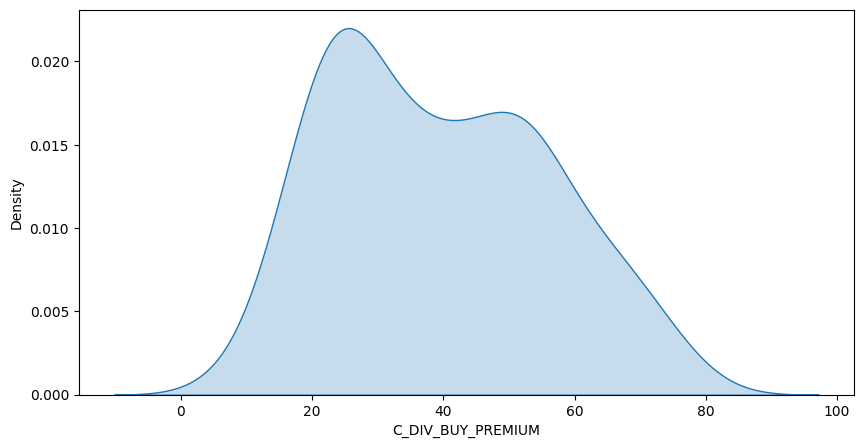

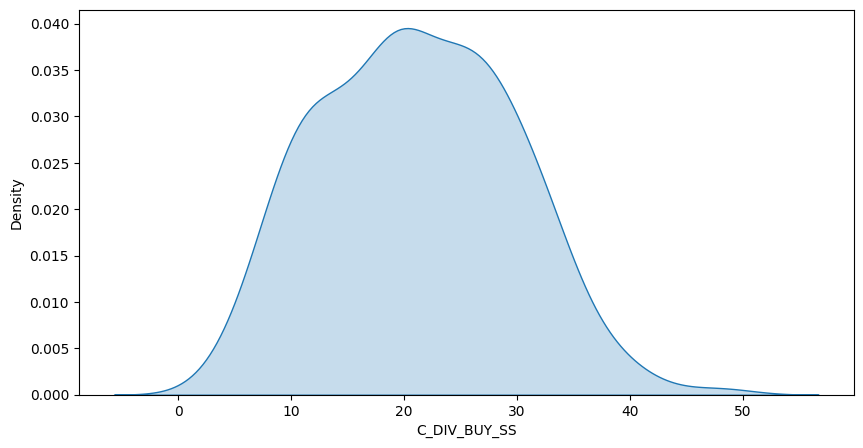

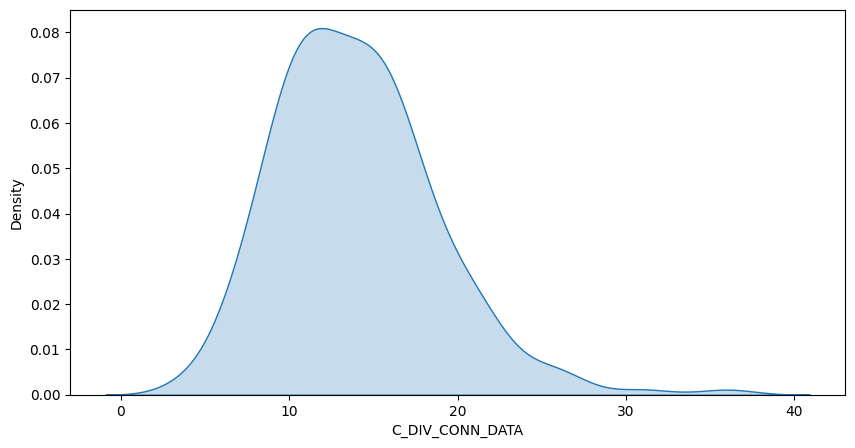

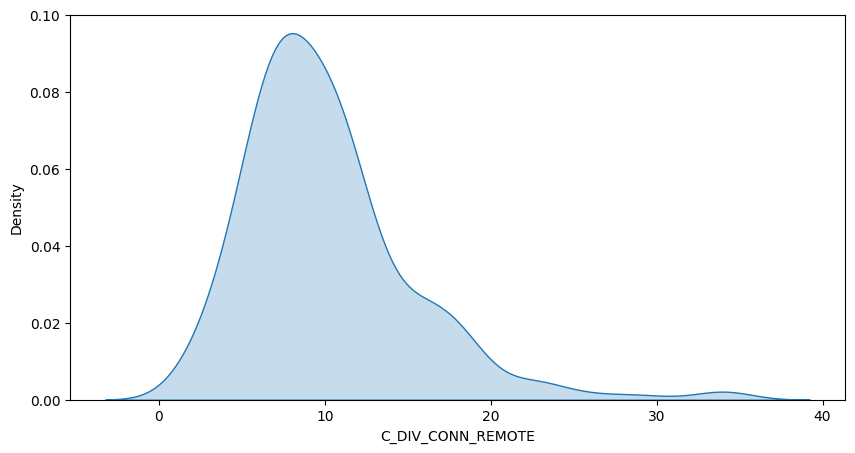

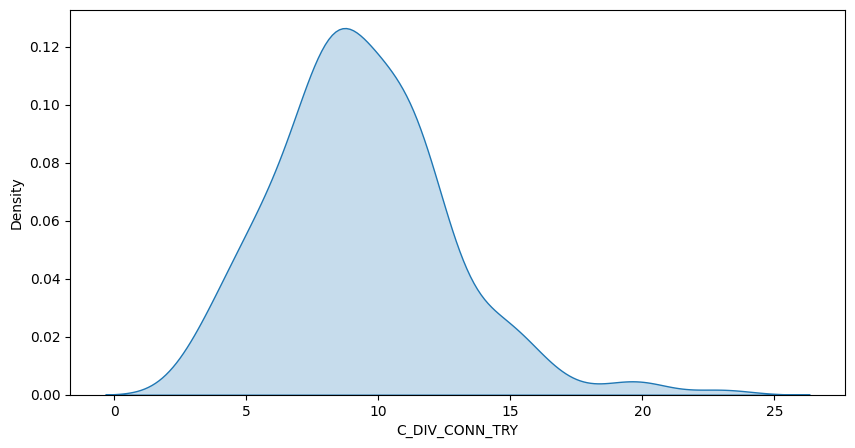

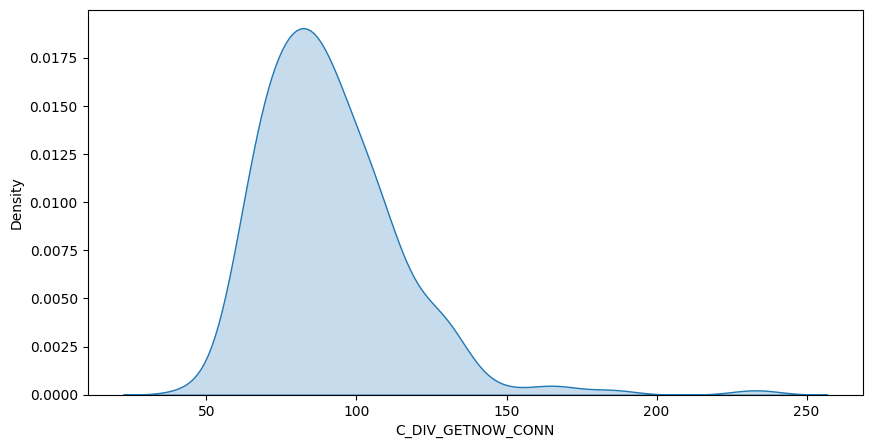

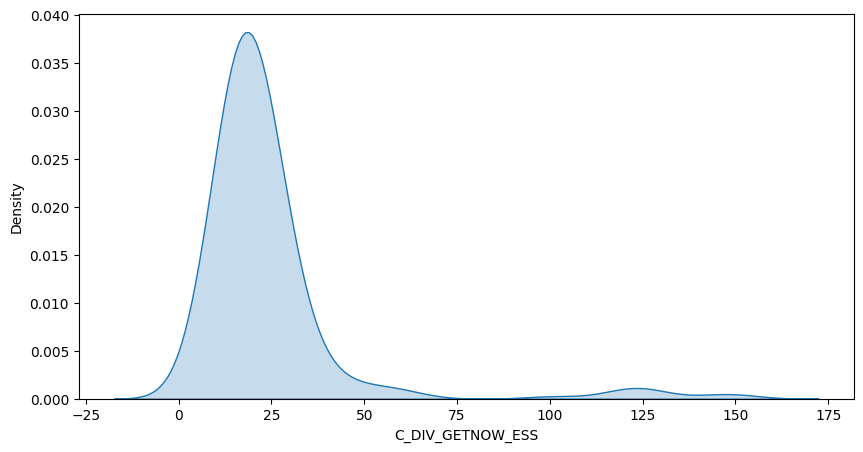

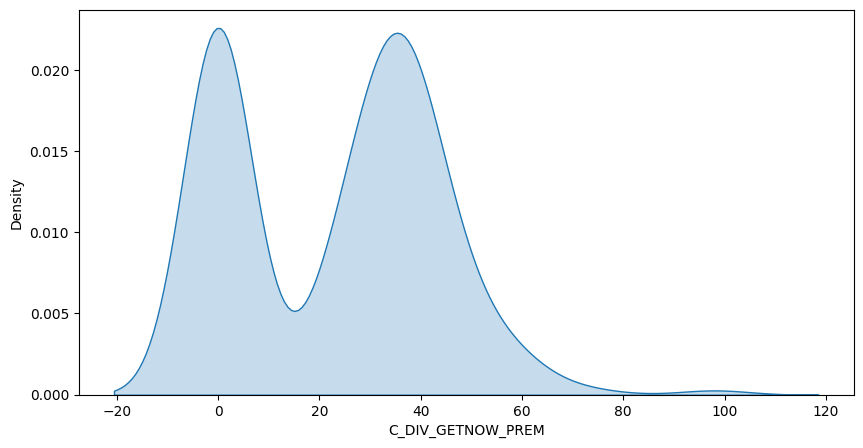

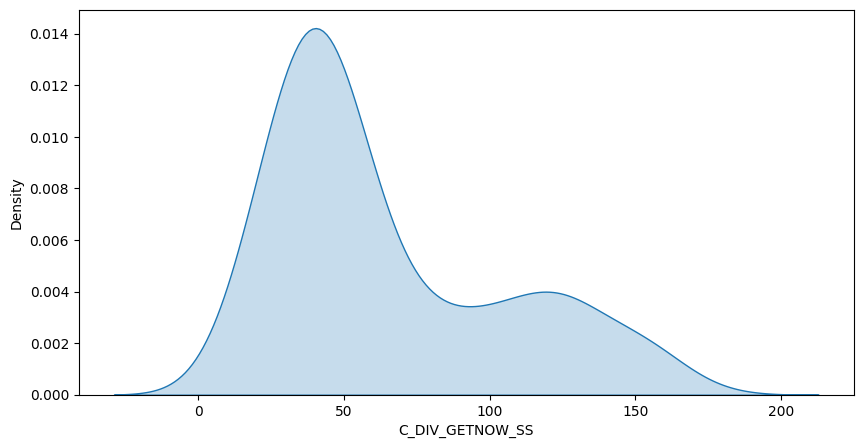

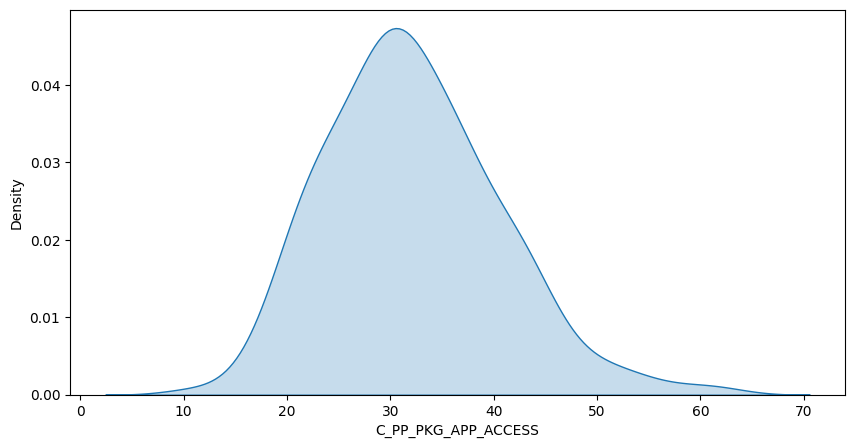

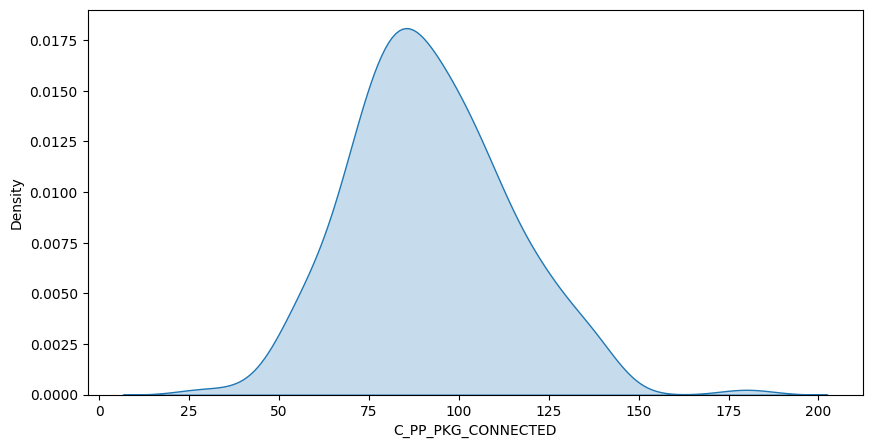

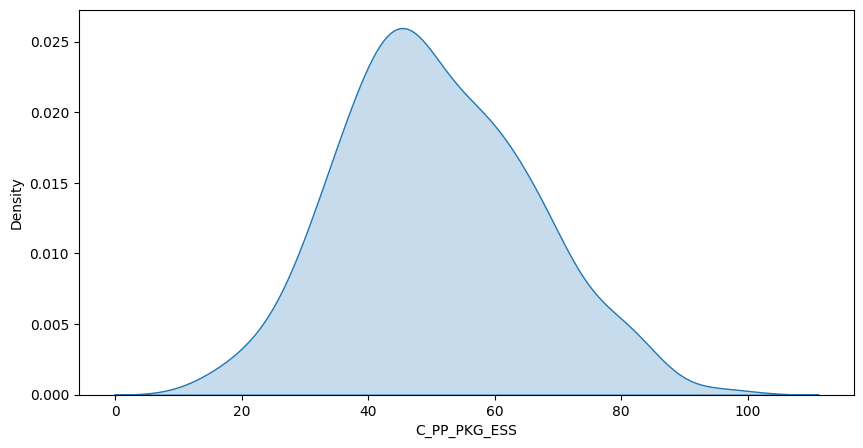

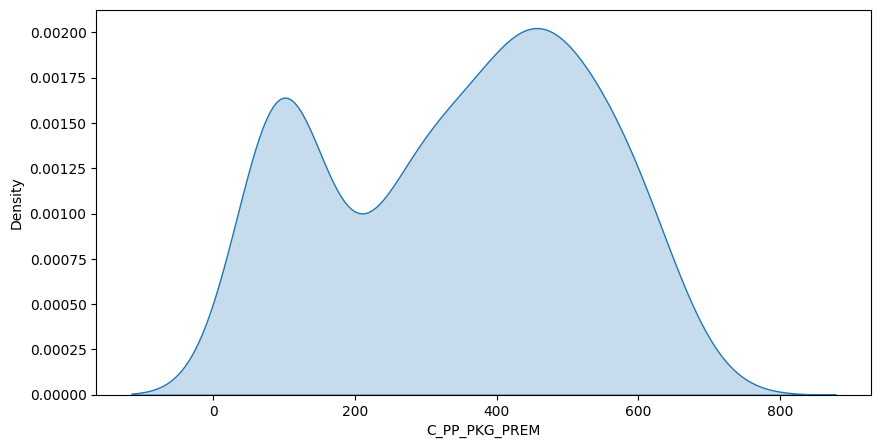

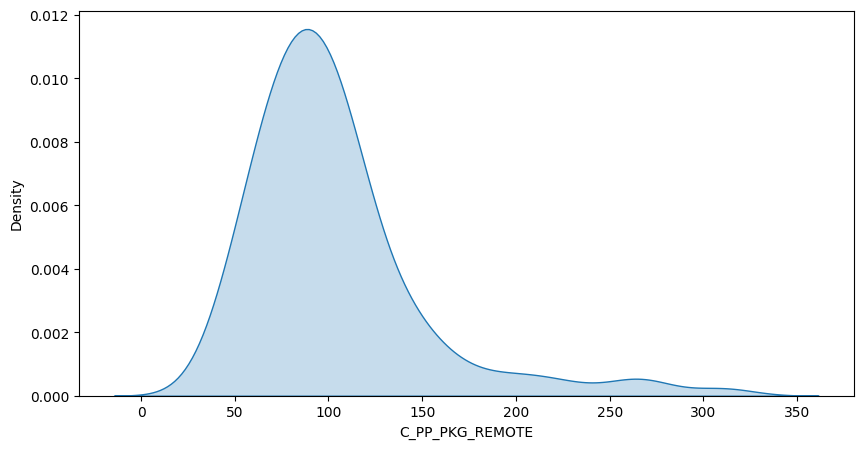

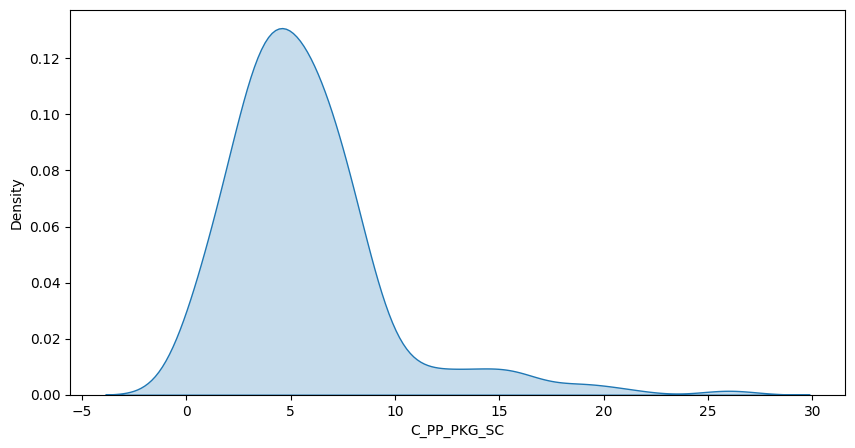

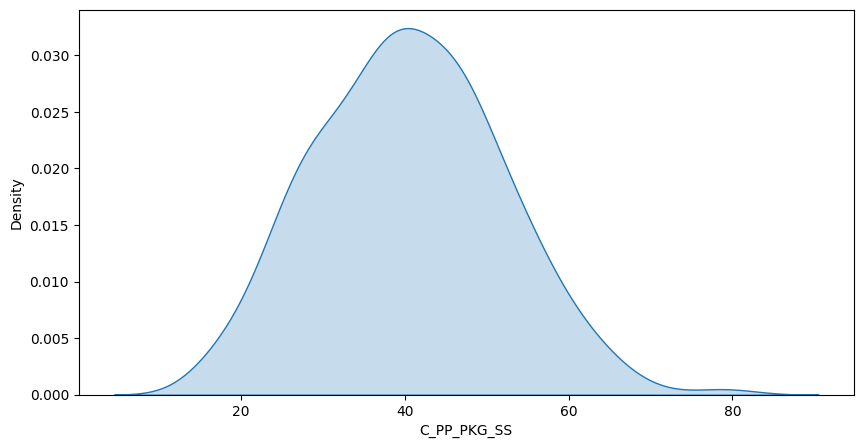

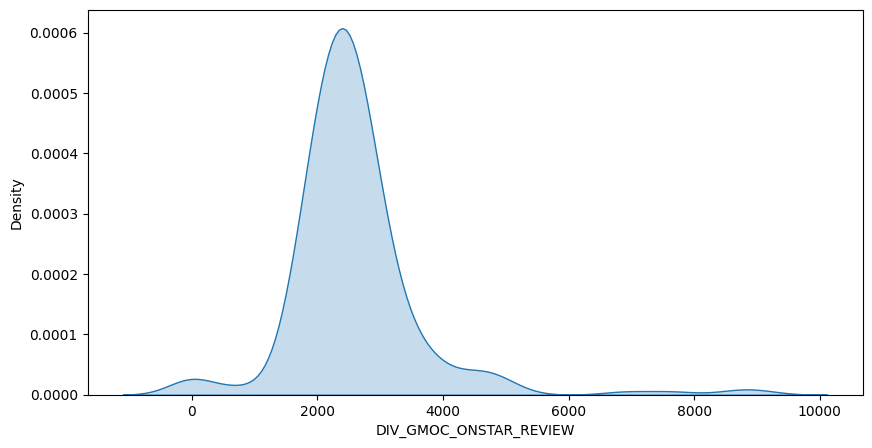

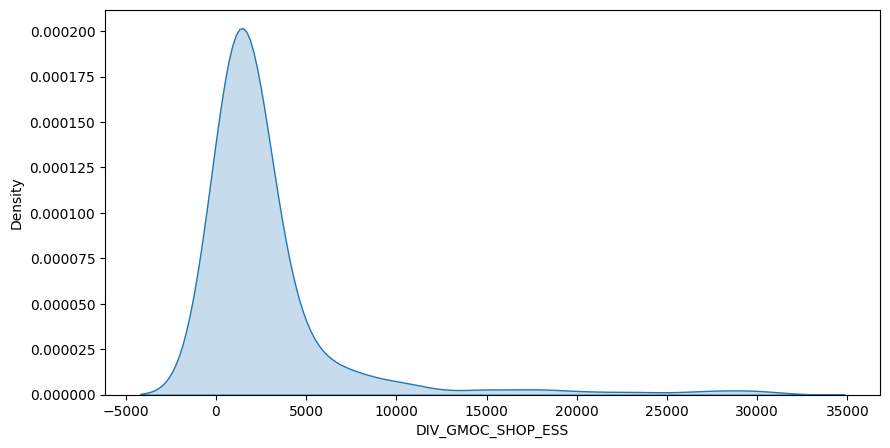

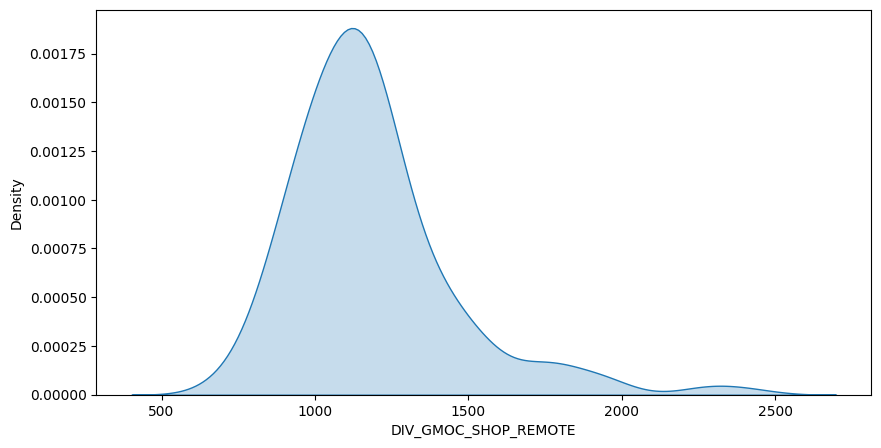

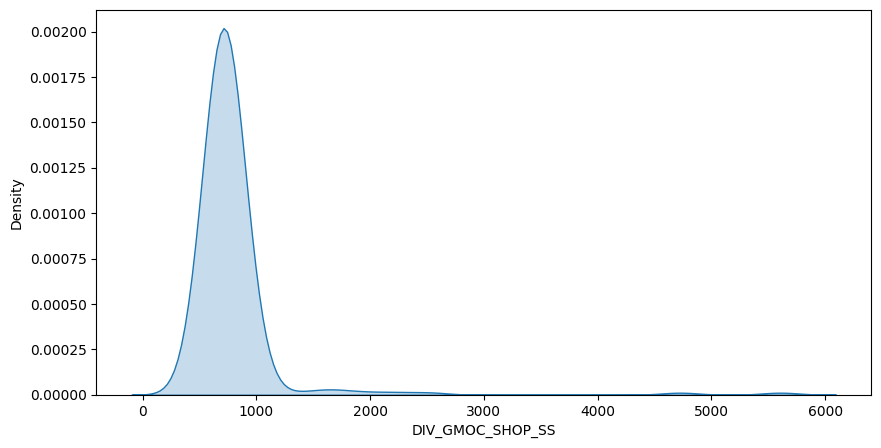

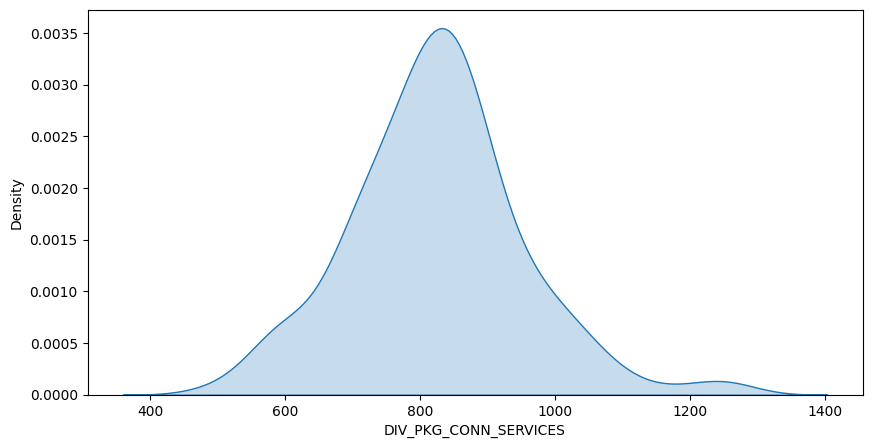

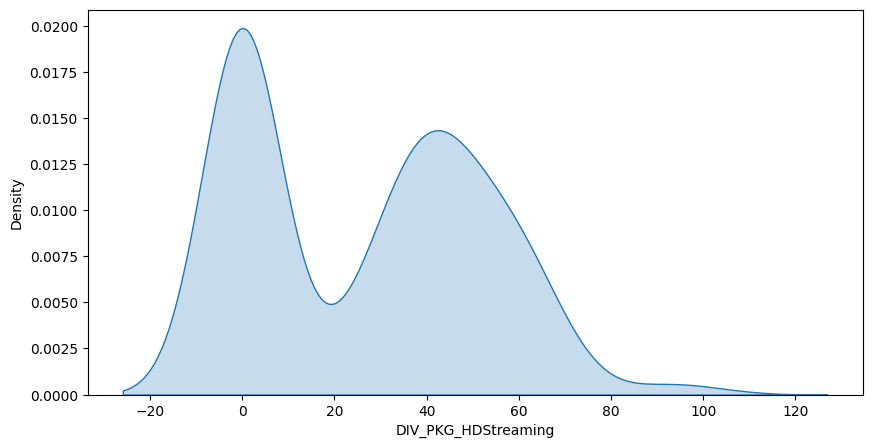

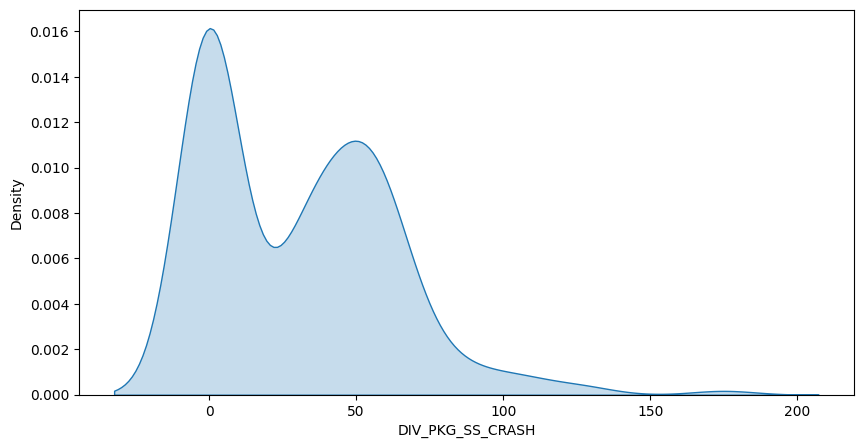

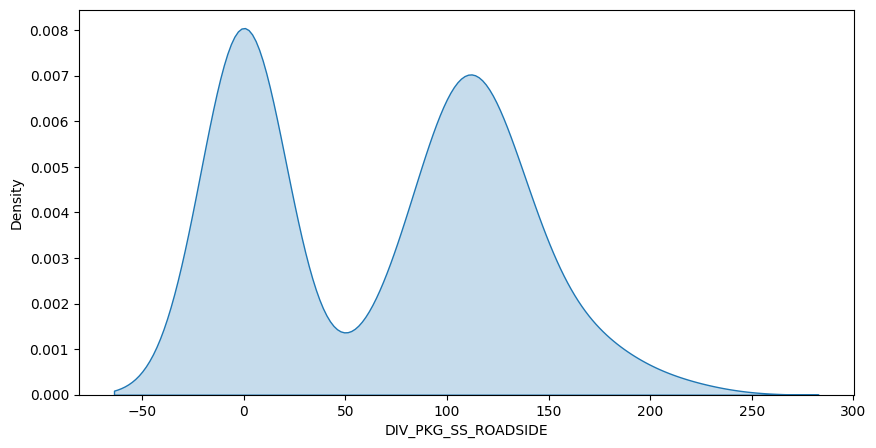

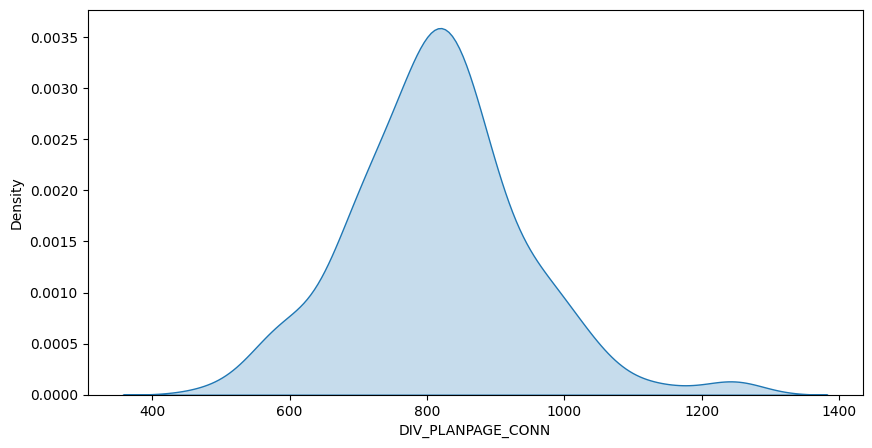

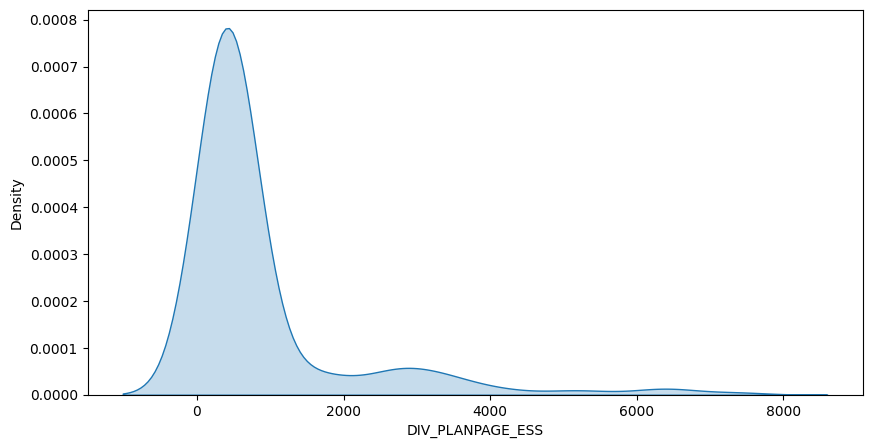

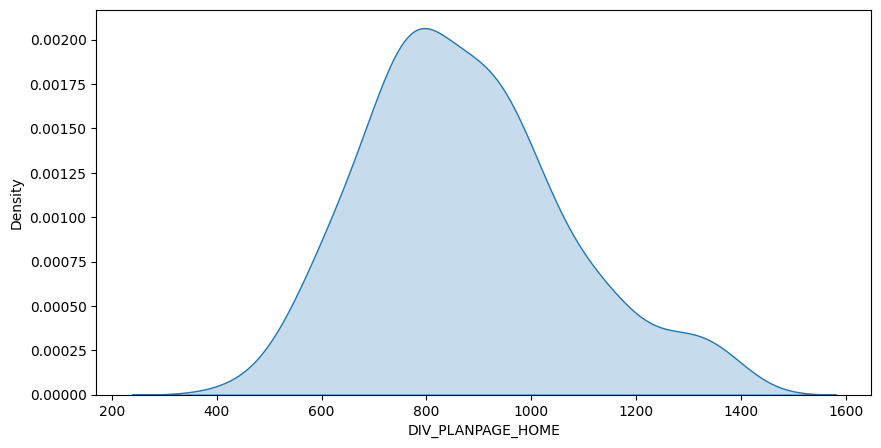

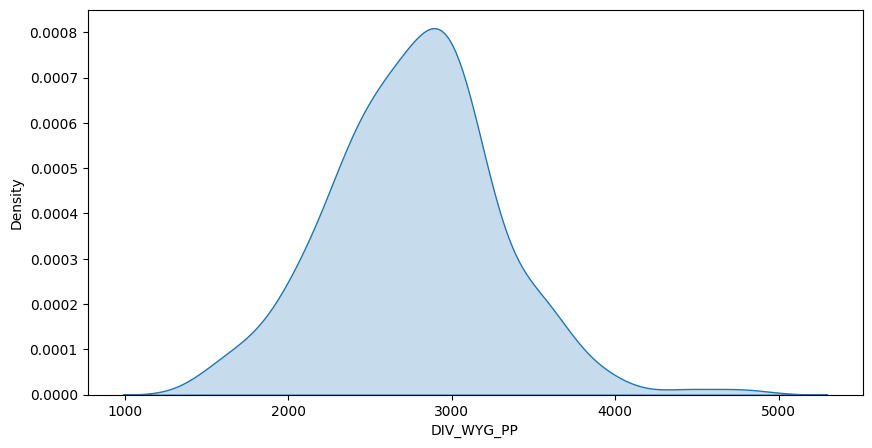

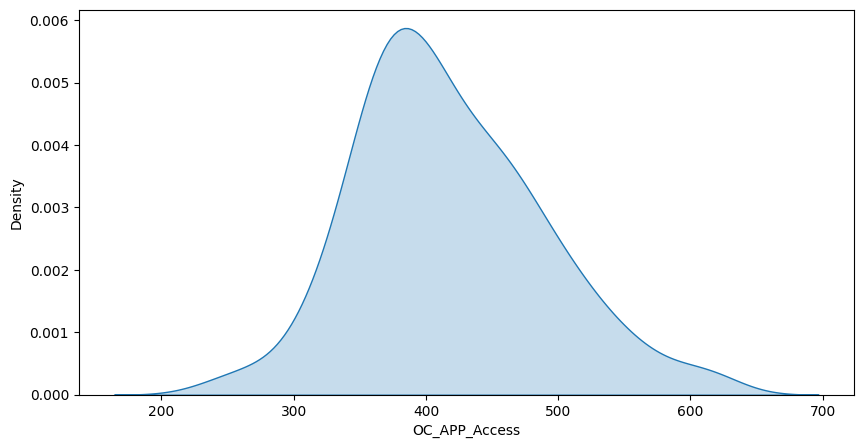

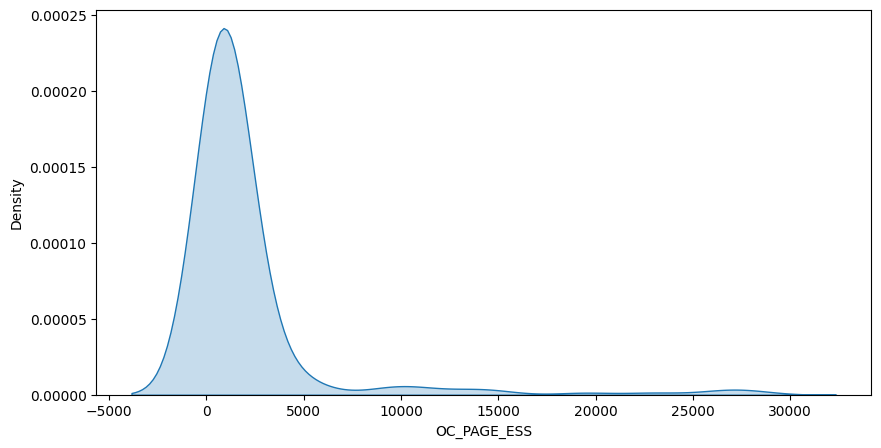

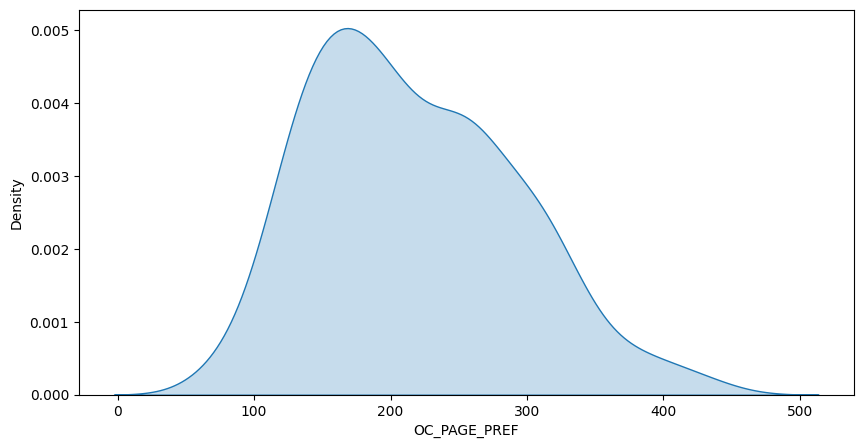

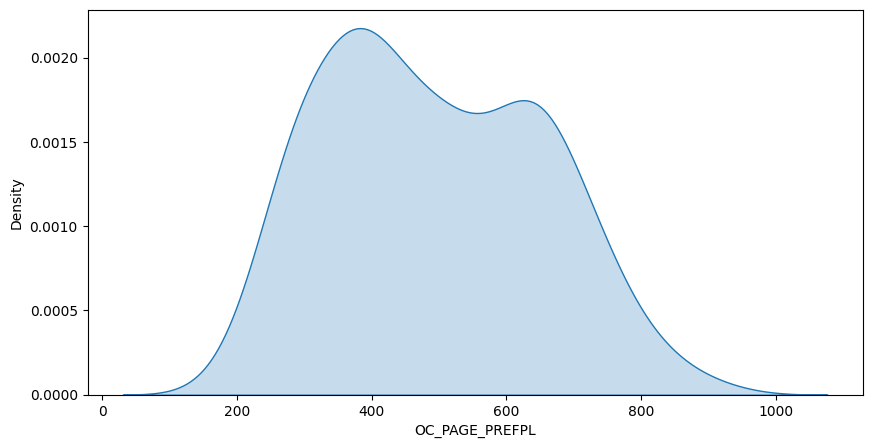

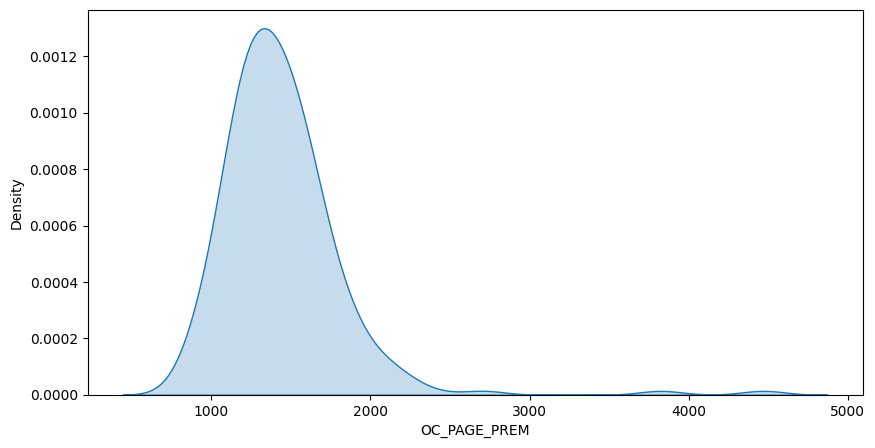

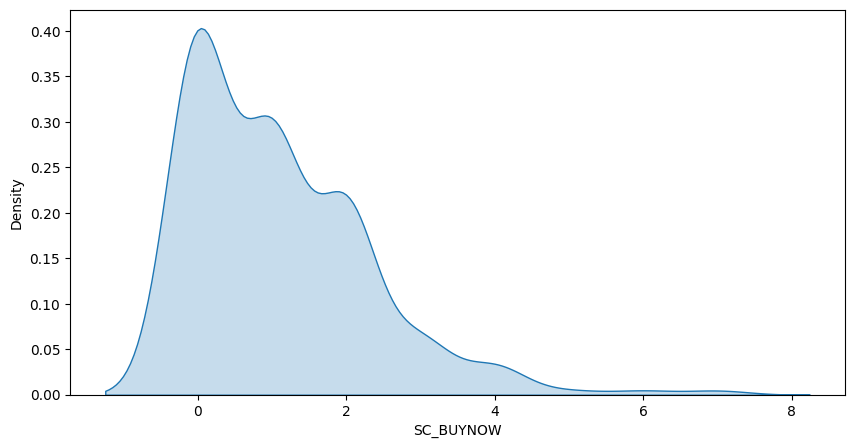

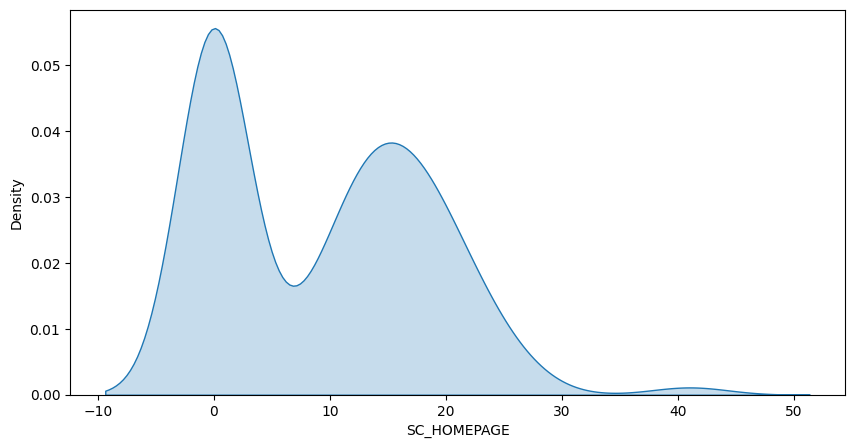

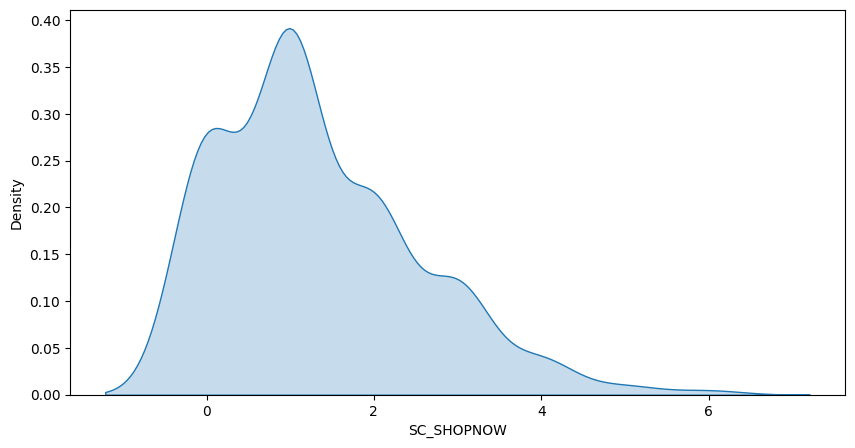

In [14]:
for i in range(2,len(featureset_df.columns)):
  plt.figure()
  sns.kdeplot(featureset_df[featureset_df.columns[i]], label = featureset_df.
              columns[i], fill = True)

## 5) Feature Creation

### 5.1) Check for Seasonality and add Flag

View the target variable as a time series plot and identify periods where data peaks.

We also add flags for periods of peak seasonality such as Q2, Q3, and major winter holidays.

Note: Please update seasonality with regards to your specific data requirements.


In [115]:
fig = px.line(df[kpi_col])
fig.show()

# 2/13/2024 - 2/19/2024 -- No Sales data
# Need to be deleted

In [116]:
## Old Sample Code

# featureset_df['Is_Q2Q3'] = (df.index.get_level_values(0).month == 4).astype(int) |
#   (df.index.get_level_values(0).month == 5).astype(int) |
#   (df.index.get_level_values(0).month == 6).astype(int) |
#   (df.index.get_level_values(0).month == 7).astype(int) |
#   (df.index.get_level_values(0).month == 8).astype(int) |
#   (df.index.get_level_values(0).month == 9).astype(int)

# featureset_df['Is_Holiday'] = ((df.index == '2017-11-17') |
#                                (df.index == '2017-12-22') |
#                                (df.index == '2018-11-16') |
#                                (df.index == '2018-12-21') |
#                                (df.index == '') | (df.index == ''))


## Update Is_Holiday flag; Thought about EOM, but not really for Google Purchase
featureset_df['Is_Holiday'] = ((df.index == '2023-11-02') |
                               (df.index == '2023-11-08') |
                               (df.index == '2023-11-20') |
                               (df.index == '2023-11-29') |
                               #added to control hikes in Nov
                               (df.index == '2023-11-23') |
                               (df.index == '2023-11-24') |
                               (df.index == '2023-12-23') |
                               (df.index == '2023-12-24') |
                               (df.index == '2023-12-25') )

## Separate out NYE since it will be negative coeff
featureset_df['Is_NYE'] = ((df.index == '2023-12-31') |(df.index == '2024-01-01') )


### 5.2) Applying Adstock Transformation

We'll need to transform the raw data by applying Adstock to have it most accurately predict the target variable.

**Adstock:** Applies an infinite lag that decreases its weight as time passes.
Media effect on sales may lag behind the original exposure and extend several weeks. More info can be found here: https://en.wikipedia.org/wiki/Advertising_adstock


Adstock takes 3 parameters (L, P, D):

L: length of the media effect

P: peak/delay of the media effect, how many days/weeks it’s lagging behind first exposure

D: decay/retention rate of the media channel, concentration of the effect

**First, split the df into two different dataframes:**

1. Features that **don't** need to be transformed
      - Examples are:
          - date
          - target variable
          - control variables (seasonality, promotions, etc.)

2. Features that **do** need to be transformed
      -  Paid media tactics
      -  Any other feature where there is some sort of delayed response with the target variable



In [117]:
'''
Variables that do not need to be transformed (i.e. Target variable + controls)

Note: In this example case, almost all of the features in the featureset_df
are media features.As more dummy variables or other control variables are added,
the user will need to specify which columns should be transformed
'''

untransformed_df = pd.concat([target_variable,
                              featureset_df[['Is_Holiday','Is_NYE']]],
                             axis = 1)

In [119]:
transformed_df_partial = featureset_df.loc[:,~featureset_df.columns.isin(untransformed_df)]

In [120]:
#transformed_df_partial.info()
untransformed_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 219 entries, 1/1/2024 to 5/9/2024
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   A_OC_GOOGLE_SHOPPING  219 non-null    int64
 1   Is_Holiday            219 non-null    bool 
 2   Is_NYE                219 non-null    bool 
dtypes: bool(2), int64(1)
memory usage: 12.0+ KB


#### 5.2.1) Create the transformation functions

This below function creates all permutations of the Adstock parameters and then calculates the correlation between each variable and the Y variable. Returns the top 3 highest correlated features.

L: fixed value. 8 if data is weekly and 21 if data is daily

P: multiple values between 1 - 7

D: multiple values between 0 - 0.48

Please note, the parameters can be adjusted in the code below.

In [121]:
def createTransformations(df1, df2):
  columns = df2.columns
  sales = df1[[kpi_col]]
  all_data = []
  for col in columns:
    newdfcolumns = []
    for l in np.linspace(21 if is_daily_data else 8,
                         21 if is_daily_data else 8, 1):
      for p in np.round(np.linspace(0, 7, 7),2):
        for d in np.round(np.linspace(0, 0.48, 9),2):
          newdf = pd.DataFrame()
          newdf[f'{col}l{l}p{p}d{d}'.replace('.','_')] = Transformation(
              df2[col], col, int(2), p, d)
          newdfcolumns.append(newdf)
    concat_new_df = pd.concat(newdfcolumns, axis=1)
    corr_df = pd.concat([sales, concat_new_df], axis=1)
    corr = abs(corr_df.corr()).sort_values(kpi_col, ascending=False)
    new_vals= corr.iloc[1:4 , 0:1].index.tolist()
    data = concat_new_df[new_vals]
    all_data.append(data)
  final_data = pd.concat(all_data,axis=1)

  return final_data

In [122]:
#This function creates every combination of Adstock

def Transformation(data, x, L, P, D):
    x_orig = data
    x_0 = np.append(np.zeros(L-1), x_orig)
    weights = np.zeros(L)
    for l in range(L):
      weight = D**((l-P)**2.0)
      weights[L-1-l] = weight
    adstocked_x = []
    for i in range(L-1, len(x_0)):
      x_array = x_0[i-L+1:i+1]
      xi = sum(x_array * weights)/sum(weights)
      adstocked_x.append(xi)
    return adstocked_x

#### 5.2.1) Execute the transformations

In [123]:
transformed_df_partial = transformed_df_partial.sort_values(date_col)
sys.setrecursionlimit(len(transformed_df_partial.index)+100)

with warnings.catch_warnings():
  warnings.simplefilter('ignore')
  transformed_df_partial = createTransformations(untransformed_df,
                                                 transformed_df_partial)
transformed_df_partial.head()

,C_DIV_BUY_CONNECTEDl21_0p0_0d0_0,C_DIV_BUY_CONNECTEDl21_0p0_0d0_06,C_DIV_BUY_CONNECTEDl21_0p0_0d0_12,C_DIV_BUY_ESSENTIALSl21_0p0_0d0_0,C_DIV_BUY_ESSENTIALSl21_0p0_0d0_06,C_DIV_BUY_ESSENTIALSl21_0p0_0d0_12,C_DIV_BUY_PREMIUMl21_0p0_0d0_0,C_DIV_BUY_PREMIUMl21_0p0_0d0_06,C_DIV_BUY_PREMIUMl21_0p0_0d0_12,C_DIV_BUY_SSl21_0p0_0d0_0,...,OC_PAGE_PREMl21_0p0_0d0_12,SC_BUYNOWl21_0p0_0d0_0,SC_BUYNOWl21_0p0_0d0_06,SC_BUYNOWl21_0p0_0d0_12,SC_HOMEPAGEl21_0p0_0d0_0,SC_HOMEPAGEl21_0p0_0d0_06,SC_HOMEPAGEl21_0p0_0d0_12,SC_SHOPNOWl21_0p0_0d0_0,SC_SHOPNOWl21_0p0_0d0_06,SC_SHOPNOWl21_0p0_0d0_12
0,30.0,28.301887,26.785714,9.0,8.490566,8.035714,17.0,16.037736,15.178571,10.0,...,842.857143,1.0,0.943396,0.892857,6.0,5.660377,5.357143,1.0,0.943396,0.892857
1,56.0,54.528302,53.214286,28.0,26.924528,25.964286,44.0,42.471698,41.107143,23.0,...,1331.500000,3.0,2.886792,2.785714,19.0,18.264151,17.607143,1.0,1.000000,1.000000
2,44.0,44.679245,45.285714,33.0,32.716981,32.464286,38.0,38.339623,38.642857,31.0,...,1511.035714,1.0,1.113208,1.214286,24.0,23.716981,23.464286,1.0,1.000000,1.000000
3,38.0,38.339623,38.642857,23.0,23.566038,24.071429,46.0,45.547170,45.142857,19.0,...,1509.142857,1.0,1.000000,1.000000,19.0,19.283019,19.535714,1.0,1.000000,1.000000
4,46.0,45.547170,45.142857,20.0,20.169811,20.321429,28.0,29.018868,29.928571,8.0,...,1578.428571,1.0,1.000000,1.000000,9.0,9.566038,10.071429,1.0,1.000000,1.000000


In [124]:
from google.colab import files
transformed_df_partial.to_csv('feature_all_adstock_transform.csv', encoding = 'utf-8-sig')
files.download('feature_all_adstock_transform.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 6) Feature Scaling

6.1) Train/Test Split & Feature Scaling

Please specify the test dataset size below.

Completing train/test split prior to standardizing and feature selection ensures no data leakate.

**Note:** use the same test % size when building the model.

In [125]:
test_size_percentage = 0.05 #@param {type:"slider", min:0, max:0.3, step:0.01}

The default method of standardization utilizes Standard Scaler, which takes in
input data and transforms so that the output has mean 0 and standard deviation of 1
across all features.


Alternative methods of feature scaling include square-root transformation,
de-meaning, natural log transformations, Min-Max Scalers, or normalization

In [126]:
test_size = round(len(transformed_df_partial.index)*test_size_percentage)

untransformed_df.reset_index(inplace=True, drop=True)
transformed_df = pd.concat(
    [transformed_df_partial, untransformed_df[untransformed_df.columns[
        untransformed_df.columns != kpi_col]]], axis = 1)
dataset_split = train_test_split(transformed_df,
                                 untransformed_df[[kpi_col]],
                                 test_size=test_size, shuffle=False)

transformed_df_train = dataset_split[0]
transformed_df_test = dataset_split[1]
transformed_df_train_target = dataset_split[2]
transformed_df_test_target = dataset_split[3]
train_scaler = StandardScaler()
standardized_array_train = train_scaler.fit_transform(transformed_df_train)
standardized_array_test = train_scaler.transform(transformed_df_test)
standardized_df_test = pd.DataFrame(
    standardized_array_test, columns = transformed_df_test.columns)
standardized_df_train = pd.DataFrame(
    standardized_array_train, columns = transformed_df_train.columns)
standardized_df_test.reset_index(inplace=True, drop=True)
standardized_df_train.reset_index(inplace=True, drop=True)
transformed_df_test_target.reset_index(inplace=True, drop=True)
transformed_df_train_target.reset_index(inplace=True, drop=True)

trimmed_transformed_standardized_train_w_target = pd.concat(
    [transformed_df_train_target, standardized_df_train], axis=1)
trimmed_transformed_standardized_train_w_o_target = standardized_df_train
trimmed_transformed_standardized_test_w_target = pd.concat(
    [transformed_df_test_target, standardized_df_test], axis=1)
trimmed_transformed_standardized_test_w_o_target = standardized_df_test

In [127]:
## Separate out datasets

#transformed_df_test_target
#trimmed_transformed_standardized_test_w_o_target
trimmed_transformed_standardized_test_w_target.head()


#transformed_df_train_target
#trimmed_transformed_standardized_train_w_target
#trimmed_transformed_standardized_test_w_o_target

,A_OC_GOOGLE_SHOPPING,C_DIV_BUY_CONNECTEDl21_0p0_0d0_0,C_DIV_BUY_CONNECTEDl21_0p0_0d0_06,C_DIV_BUY_CONNECTEDl21_0p0_0d0_12,C_DIV_BUY_ESSENTIALSl21_0p0_0d0_0,C_DIV_BUY_ESSENTIALSl21_0p0_0d0_06,C_DIV_BUY_ESSENTIALSl21_0p0_0d0_12,C_DIV_BUY_PREMIUMl21_0p0_0d0_0,C_DIV_BUY_PREMIUMl21_0p0_0d0_06,C_DIV_BUY_PREMIUMl21_0p0_0d0_12,...,SC_BUYNOWl21_0p0_0d0_06,SC_BUYNOWl21_0p0_0d0_12,SC_HOMEPAGEl21_0p0_0d0_0,SC_HOMEPAGEl21_0p0_0d0_06,SC_HOMEPAGEl21_0p0_0d0_12,SC_SHOPNOWl21_0p0_0d0_0,SC_SHOPNOWl21_0p0_0d0_06,SC_SHOPNOWl21_0p0_0d0_12,Is_Holiday,Is_NYE
0,868,0.372025,0.444335,0.509951,0.569121,0.572466,0.574255,0.667683,0.670523,0.672243,...,-0.941196,-0.986532,-1.070748,-1.085692,-1.097973,-0.271419,-0.236123,-0.200507,0.0,0.0
1,825,0.611299,0.607327,0.602861,0.788744,0.797987,0.804772,1.680955,1.646005,1.611891,...,-0.138207,-0.189953,-1.070748,-1.085692,-1.097973,1.389025,1.365768,1.338075,0.0,0.0
2,757,0.563444,0.575278,0.585331,0.239685,0.278863,0.314923,0.548474,0.621521,0.687504,...,-0.090027,-0.094364,-1.070748,-1.085692,-1.097973,-0.271419,-0.186580,-0.102299,0.0,0.0
3,758,0.946283,0.938805,0.930675,1.777050,1.736239,1.693910,0.608078,0.613544,0.617739,...,-0.090027,-0.094364,-1.070748,-1.085692,-1.097973,-0.271419,-0.285666,-0.298714,0.0,0.0
4,851,1.185557,1.189702,1.191875,0.898556,0.974574,1.043522,1.919372,1.870502,1.823366,...,-0.893017,-0.890942,-1.070748,-1.085692,-1.097973,-0.271419,-0.285666,-0.298714,0.0,0.0


Option to review visuals of the data. After the data is standardized the distributions may take on a more normal shape.

In [31]:
'''

for i in range(0,len(trimmed_transformed_standardized_train_w_o_target.columns)):
  plt.figure()
  sns.kdeplot(trimmed_transformed_standardized_train_w_o_target[
      trimmed_transformed_standardized_train_w_o_target.columns[i]], label =
      trimmed_transformed_standardized_train_w_o_target.columns[i], shade = True)

'''

'\n\nfor i in range(0,len(trimmed_transformed_standardized_train_w_o_target.columns)):\n  plt.figure()\n  sns.kdeplot(trimmed_transformed_standardized_train_w_o_target[\n      trimmed_transformed_standardized_train_w_o_target.columns[i]], label =\n      trimmed_transformed_standardized_train_w_o_target.columns[i], shade = True)\n\n'

## 7) Feature Selection

For feature selection we employ the Boruta algorithm.[(More information here)](https://towardsdatascience.com/boruta-explained-the-way-i-wish-someone-explained-it-to-me-4489d70e154a
)

This algorithm will tell you the rank of each feature and whether or not to keep a varaible in the model (i.e. Keep  = True/False). The goal of RBA is to optimize across all paid digital media tactics, therefore select the top ranking feature for each group of features (whether or not the algorithm tells you to keep the feature).


In [146]:
# Specifiying the target and x variables
num_train_samples = transformed_df_train_target.shape[0]

y = transformed_df_train_target.to_numpy().reshape(num_train_samples,)
x = trimmed_transformed_standardized_train_w_o_target

In [147]:
# define random forest classifier
forest = RandomForestRegressor(n_jobs=-1, max_depth=5)
forest.fit(x, y)

RandomForestRegressor(max_depth=5, n_jobs=-1)

In [ ]:
#pip install numpy==1.19.5

# import numpy as np
# import boruta
# print(f"NumPy version: {np.__version__}")


NumPy version: 1.25.2


In [34]:
#pip show boruta

In [148]:
### fix for boruta feature selection
np.int = int
np.float = float
np.bool = bool

In [149]:
with warnings.catch_warnings():
  warnings.simplefilter('ignore')
  # define Boruta feature selection method
  feat_selector = BorutaPy(
      forest, n_estimators='auto', verbose=0, random_state=1)

  # find all relevant features
  feat_selector.fit(np.array(x), np.array(y))

  # check selected features
  feat_selector.support_

  # check ranking of features
  feat_selector.ranking_

  # call transform() on X to filter it down to selected features
  X_filtered = feat_selector.transform(np.array(x))

In [150]:
#Select the top ranking variable for each group of variables.
feature_ranks = list(zip(x.columns,
                         feat_selector.ranking_,
                         feat_selector.support_))

# iterate through and print out the results
for feat in feature_ranks:
    print('{:<25}, Rank: {},  Keep: {}'.format(feat[0], feat[1], feat[2]))

C_DIV_BUY_CONNECTEDl21_0p0_0d0_0, Rank: 70,  Keep: False
C_DIV_BUY_CONNECTEDl21_0p0_0d0_06, Rank: 62,  Keep: False
C_DIV_BUY_CONNECTEDl21_0p0_0d0_12, Rank: 48,  Keep: False
C_DIV_BUY_ESSENTIALSl21_0p0_0d0_0, Rank: 35,  Keep: False
C_DIV_BUY_ESSENTIALSl21_0p0_0d0_06, Rank: 32,  Keep: False
C_DIV_BUY_ESSENTIALSl21_0p0_0d0_12, Rank: 25,  Keep: False
C_DIV_BUY_PREMIUMl21_0p0_0d0_0, Rank: 51,  Keep: False
C_DIV_BUY_PREMIUMl21_0p0_0d0_06, Rank: 75,  Keep: False
C_DIV_BUY_PREMIUMl21_0p0_0d0_12, Rank: 47,  Keep: False
C_DIV_BUY_SSl21_0p0_0d0_0, Rank: 71,  Keep: False
C_DIV_BUY_SSl21_0p0_0d0_06, Rank: 62,  Keep: False
C_DIV_BUY_SSl21_0p0_0d0_12, Rank: 72,  Keep: False
C_DIV_CONN_DATAl21_0p0_0d0_0, Rank: 89,  Keep: False
C_DIV_CONN_DATAl21_0p0_0d0_06, Rank: 67,  Keep: False
C_DIV_CONN_DATAl21_0p0_0d0_12, Rank: 65,  Keep: False
C_DIV_CONN_REMOTEl21_0p0_0d0_0, Rank: 52,  Keep: False
C_DIV_CONN_REMOTEl21_0p0_0d0_06, Rank: 40,  Keep: False
C_DIV_CONN_REMOTEl21_0p0_0d0_12, Rank: 22,  Keep: False
C_DI

Function to reduce the overall dataset to the lowest rank feature from the Boruta output, and save to a dataframe

In [151]:
def stripQualifiers(column, leading=True):
  retString = column
  if retString.startswith('cost_') and leading:
    retString = retString.split('cost_')[1]
  if retString.startswith('Paid_') and leading:
    retString = retString.split('Paid_')[1]
  try:
    int(retString[::-1][retString[::-1].find('l')-1])
    retString = retString[::-1][retString[::-1].find('l')+1:][::-1]
    return retString
  except:
    return retString

keepers = {}
for feat in feature_ranks:
    #print('{:<25}, Rank: {},  Keep: {}'.format(feat[0], feat[1], feat[2]))
    featureName = stripQualifiers(feat[0], True)
    if keepers.get(featureName) is None:
      keepers[featureName] = {'fullColumnName': feat[0], 'rank': feat[1]}
    else:
      if keepers[featureName]['rank'] > feat[1]:
        keepers[featureName] = {'fullColumnName': feat[0], 'rank': feat[1]}

selected_featureset_df = trimmed_transformed_standardized_train_w_o_target.drop(
    columns=[col for col in trimmed_transformed_standardized_train_w_o_target
             if col not in [keepers[i]['fullColumnName'] for i in keepers.keys()]])

selected_featureset_df.head()

,C_DIV_BUY_CONNECTEDl21_0p0_0d0_12,C_DIV_BUY_ESSENTIALSl21_0p0_0d0_12,C_DIV_BUY_PREMIUMl21_0p0_0d0_12,C_DIV_BUY_SSl21_0p0_0d0_06,C_DIV_CONN_DATAl21_0p0_0d0_12,C_DIV_CONN_REMOTEl21_0p0_0d0_12,C_DIV_CONN_TRYl21_0p0_0d0_12,C_DIV_GETNOW_CONNl21_0p0_0d0_12,C_DIV_GETNOW_ESSl21_0p0_0d0_12,C_DIV_GETNOW_PREMl21_0p0_0d0_06,...,OC_APP_Accessl21_0p0_0d0_12,OC_PAGE_ESSl21_0p0_0d0_0,OC_PAGE_PREFl21_0p0_0d0_12,OC_PAGE_PREFPLl21_0p0_0d0_06,OC_PAGE_PREMl21_0p0_0d0_12,SC_BUYNOWl21_0p0_0d0_06,SC_HOMEPAGEl21_0p0_0d0_12,SC_SHOPNOWl21_0p0_0d0_06,Is_Holiday,Is_NYE
0,-1.295657,-1.817362,-1.440329,-1.369822,-0.704553,-1.401254,-1.884490,-1.190615,-0.640545,0.081945,...,-2.777969,-0.365928,-1.926787,-1.300644,-1.568251,-0.138207,-0.495582,-0.335209,0.0,0.0
1,0.001576,0.249061,0.142465,0.157951,-0.816409,1.652477,-0.862317,-0.920144,-0.143078,1.642490,...,-0.719571,-0.317697,-1.200117,-0.589885,-0.262988,1.515951,0.881885,-0.285666,0.0,0.0
2,-0.387594,0.998242,-0.007966,1.144264,0.134365,1.267055,-0.169119,-0.569651,0.424964,2.449075,...,0.730095,-0.295236,-0.619555,-0.388711,0.216588,0.006331,1.540499,-0.285666,0.0,0.0
3,-0.713655,0.030893,0.388823,-0.149850,-0.744501,1.178111,-0.686080,0.153741,0.056597,1.774529,...,0.294449,-0.319352,-0.631166,-0.549509,0.211532,-0.090027,1.098746,-0.285666,0.0,0.0
4,-0.394606,-0.401327,-0.539924,-1.466431,0.134365,0.622213,-0.169119,-0.684881,0.004957,0.822510,...,1.036325,-0.296418,-0.615684,-0.618607,0.396608,-0.090027,0.034522,-0.285666,0.0,0.0


In [152]:
## Output selected_featureset_df

selected_featureset_df.to_csv('selected_feasureset.csv', index= True)

from google.colab import files
files.download('selected_feasureset.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 8) Handle Multicollinearity (reduce feature set)

1. Print a correlation heatmap to visualize correlations across feature set
2. Run variance inflation factor analysis and output results to flag multicollinearity above specified threshold

<Axes: >

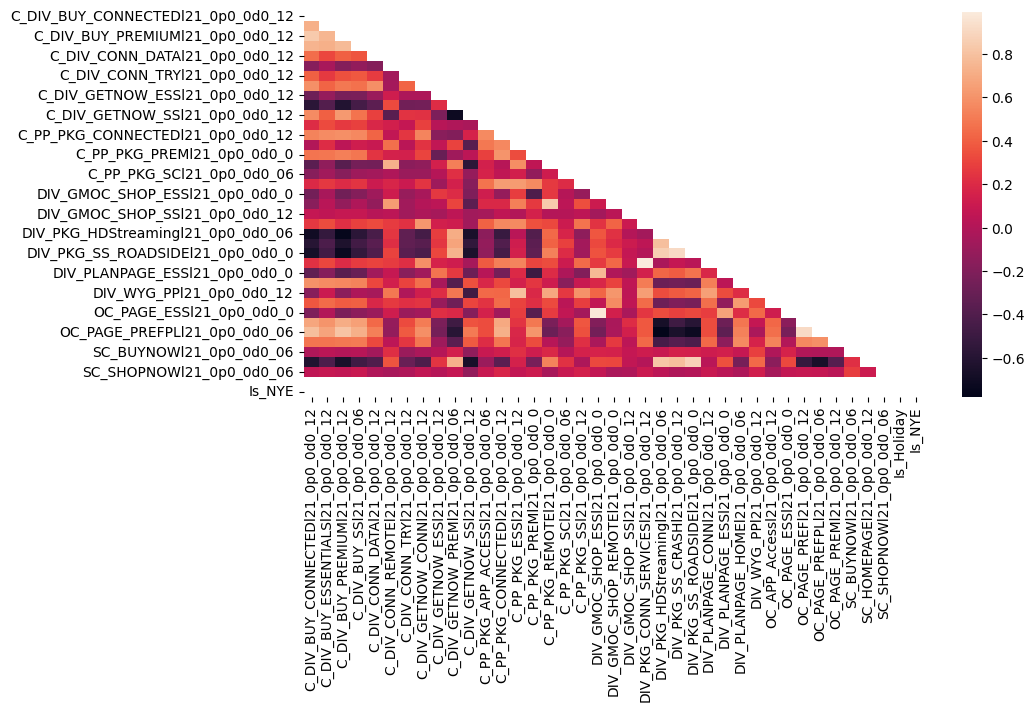

In [153]:
correl = selected_featureset_df.corr()

# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(correl)

# using the upper triangle matrix as mask
sns.heatmap(correl, mask=matrix)

Run VIF analysis and flag values greater than 10.

Industry best practice flags values above 10 as an extreme violation of regression model assumptions. [(Reference)](https://en.wikipedia.org/wiki/Variance_inflation_factor)


In [157]:
vif = add_constant(selected_featureset_df)

# loop to calculate the VIF for each X
vif = pd.Series([variance_inflation_factor(vif.values, i)
      for i in range(vif.shape[1])],
      index=vif.columns)

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning:

invalid value encountered in scalar divide



In [137]:
# processing to output VIF results as a dataframe
vif_df=vif.to_frame().reset_index()

vif_df.columns = ['feature', 'vif']
vif_df=vif_df.replace([np.inf], np.nan)
vif_df=vif_df.fillna(0).sort_values(by="vif", ascending=False)

In [138]:
vif_df.reset_index(inplace = True)
vif_df

,index,feature,vif
0,22,DIV_PKG_CONN_SERVICESl21_0p0_0d0_12,352.630140
1,26,DIV_PLANPAGE_CONNl21_0p0_0d0_12,347.529914
2,19,DIV_GMOC_SHOP_ESSl21_0p0_0d0_0,57.915547
3,31,OC_PAGE_ESSl21_0p0_0d0_0,45.285579
4,33,OC_PAGE_PREFPLl21_0p0_0d0_06,21.732186
5,25,DIV_PKG_SS_ROADSIDEl21_0p0_0d0_0,17.648175
6,29,DIV_WYG_PPl21_0p0_0d0_12,12.039721
7,32,OC_PAGE_PREFl21_0p0_0d0_12,11.149492
8,16,C_PP_PKG_REMOTEl21_0p0_0d0_0,9.747259
9,24,DIV_PKG_SS_CRASHl21_0p0_0d0_12,8.941160


Drop the highest VIF features and print the high collinearity columns in a list

In [139]:
high_collinearity_columns = vif_df.feature[vif_df['vif'] >= 10].to_list()
high_collinearity_columns

['DIV_PKG_CONN_SERVICESl21_0p0_0d0_12',
 'DIV_PLANPAGE_CONNl21_0p0_0d0_12',
 'DIV_GMOC_SHOP_ESSl21_0p0_0d0_0',
 'OC_PAGE_ESSl21_0p0_0d0_0',
 'OC_PAGE_PREFPLl21_0p0_0d0_06',
 'DIV_PKG_SS_ROADSIDEl21_0p0_0d0_0',
 'DIV_WYG_PPl21_0p0_0d0_12',
 'OC_PAGE_PREFl21_0p0_0d0_12']

In [140]:
#vif_df

In [142]:
#vif_df.info()

Drop 1 variable at a time (start with the highest VIF) and re-run the VIF cell to re-check multicollinearity. This will allow the user to preserve as many features in the model as possible.

In [144]:
cols_to_drop = []
while vif_df.vif[1] >= 10:
  if vif_df.vif[1] >= 10:
    cols_to_drop.append(vif_df.feature[1])
    selected_featureset_df.drop(columns = vif_df.feature[1],inplace = True)
    vif = add_constant(selected_featureset_df)
  # loop to calculate the VIF for each X
    vif = pd.Series([variance_inflation_factor(vif.values, i)
    for i in range(vif.shape[1])], index=vif.columns)
    # processing to output VIF results as a dataframe
    vif_df=vif.to_frame().reset_index()
    vif_df.columns = ['feature', 'vif']
    vif_df=vif_df.replace([np.inf], np.nan)
    vif_df=vif_df.fillna(0).sort_values(by="vif", ascending=False)
    vif_df.reset_index(inplace = True)

In [145]:
cols_to_drop

[]

In [97]:
selected_featureset_df.head()

,C_DIV_BUY_CONNECTEDl21_0p0_0d0_06,C_DIV_BUY_ESSENTIALSl21_0p0_0d0_06,C_DIV_BUY_PREMIUMl21_0p0_0d0_06,C_DIV_BUY_SSl21_0p0_0d0_12,C_DIV_CONN_DATAl21_0p0_0d0_12,C_DIV_CONN_REMOTEl21_0p0_0d0_12,C_DIV_CONN_TRYl21_0p0_0d0_12,C_DIV_GETNOW_CONNl21_0p0_0d0_12,C_DIV_GETNOW_ESSl21_0p0_0d0_12,C_DIV_GETNOW_PREMl21_0p0_0d0_0,...,DIV_PLANPAGE_HOMEl21_0p0_0d0_0,OC_APP_Accessl21_0p0_0d0_06,OC_PAGE_PREFl21_0p0_0d0_0,OC_PAGE_PREFPLl21_0p0_0d0_12,OC_PAGE_PREMl21_0p0_0d0_12,SC_BUYNOWl21_0p0_0d0_12,SC_HOMEPAGEl21_0p0_0d0_06,SC_SHOPNOWl21_0p0_0d0_12,Is_Holiday,Is_NYE
0,-1.295751,-0.446844,-1.194541,-0.474351,-0.705212,-0.093944,-0.712092,0.307500,-0.159000,0.711753,...,-0.542268,-0.693878,-0.812114,-1.450006,-0.612203,-1.013031,0.800494,-0.435712,-0.212664,-0.098533
1,-1.125317,-1.787173,-0.955605,-0.772672,0.808002,-0.579551,-0.129897,0.195958,-0.163912,0.711753,...,-0.787179,-0.566780,-1.048733,-1.284105,-0.663551,-1.013031,0.599578,0.506578,-0.212664,-0.098533
2,-1.582895,-2.085959,-1.855596,-1.496538,-1.079448,-1.391312,0.499824,-0.995954,-0.301446,0.510469,...,-1.817847,-0.687852,-1.482535,-1.478292,-1.195888,-1.013031,0.580742,-1.075122,-0.212664,-0.098533
3,-1.193861,-1.572552,-0.999979,-0.698092,-0.916737,-0.572303,-1.508155,-0.811112,-0.643643,0.208542,...,-0.771872,0.757340,-0.102257,-0.777197,-0.168277,0.603343,0.685386,-1.277042,-0.212664,-0.098533
4,-1.307792,-1.435784,-1.002255,-1.470215,-0.664534,-0.825978,-1.460628,-0.334666,1.240898,0.359505,...,-0.424915,0.104867,-0.115402,-1.071958,-0.427817,-0.819067,0.063802,-1.277042,-0.212664,-0.098533


In [98]:
selected_featureset_df.columns

Index(['C_DIV_BUY_CONNECTEDl21_0p0_0d0_06',
       'C_DIV_BUY_ESSENTIALSl21_0p0_0d0_06', 'C_DIV_BUY_PREMIUMl21_0p0_0d0_06',
       'C_DIV_BUY_SSl21_0p0_0d0_12', 'C_DIV_CONN_DATAl21_0p0_0d0_12',
       'C_DIV_CONN_REMOTEl21_0p0_0d0_12', 'C_DIV_CONN_TRYl21_0p0_0d0_12',
       'C_DIV_GETNOW_CONNl21_0p0_0d0_12', 'C_DIV_GETNOW_ESSl21_0p0_0d0_12',
       'C_DIV_GETNOW_PREMl21_0p0_0d0_0', 'C_DIV_GETNOW_SSl21_0p0_0d0_12',
       'C_PP_PKG_APP_ACCESSl21_0p0_0d0_06', 'C_PP_PKG_CONNECTEDl21_0p0_0d0_12',
       'C_PP_PKG_ESSl21_0p0_0d0_12', 'C_PP_PKG_PREMl21_0p0_0d0_06',
       'C_PP_PKG_REMOTEl21_0p0_0d0_12', 'C_PP_PKG_SCl21_0p0_0d0_12',
       'C_PP_PKG_SSl21_0p0_0d0_12', 'DIV_GMOC_ONSTAR_REVIEWl21_0p0_0d0_0',
       'DIV_GMOC_SHOP_REMOTEl21_0p0_0d0_0', 'DIV_GMOC_SHOP_SSl21_0p0_0d0_0',
       'DIV_PKG_CONN_SERVICESl21_0p0_0d0_0',
       'DIV_PKG_HDStreamingl21_0p0_0d0_12', 'DIV_PKG_SS_CRASHl21_0p0_0d0_06',
       'DIV_PLANPAGE_ESSl21_0p0_0d0_0', 'DIV_PLANPAGE_HOMEl21_0p0_0d0_0',
       'OC_APP_A

In [99]:
len(selected_featureset_df.columns)

35

## 9) Export Final Dataset

### 9.1) Export data for model building


In [100]:
final_df = pd.concat([trimmed_transformed_standardized_train_w_o_target,
                      trimmed_transformed_standardized_test_w_o_target])
final_df = final_df[final_df.columns[final_df.columns.isin(
    selected_featureset_df.columns)]]
final_df.reset_index(inplace=True, drop=True)
final_df[kpi_col] = target_variable.reset_index()[kpi_col]

In [101]:
final_df[date_col] = df.index #add back in the date as a separate column from the index
final_df[date_col] = final_df[date_col].astype('string')

In [102]:
## Output final_df

final_df.to_csv('final_cleaned_data.csv', index= False)

from google.colab import files
files.download('final_cleaned_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# destination_project_id = " " #@param {type:"string"}
# destination_dataset = "RBA_demo" #@param {type:"string"}
# destination_table = "cleaned_data" #@param {type:"string"}
# dataset_table = destination_dataset+"."+destination_table

# final_df.to_gbq(dataset_table,
#                  destination_project_id,
#                  chunksize=None,
#                  if_exists='replace'
#                  )

### 9.2) Prepare the data for optimization tool

The budget optimization tool requires the model features in their original un-transformed state as an input. The following function pulls the names of the required columns and collects the data from the relevant dataframes.

In [ ]:
def parse_final_column_features(columns):
  final = []
  for col in columns:
    if any(char.isdigit() for char in col):
      splitList = col[::-1].split('l', 1)
      parsed = (splitList[1] if len(splitList) > 1 else splitList[0])
      final.append(parsed[::-1])
    else:
      final.append(col)
  return final

In [ ]:
df[df.columns[df.columns.isin(parse_final_column_features(selected_featureset_df.columns))]].head()

In [ ]:
optimizer_df = df[df.columns[df.columns.isin(parse_final_column_features(
    selected_featureset_df.columns))]]
optimizer_df.reset_index(inplace=True, drop = True)
#optimizer_df[date_col] = optimizer_df[date_col].astype('string')
target_variable.reset_index(inplace=True, drop=True)
optimizer_df[kpi_col] = target_variable

In [ ]:
destination_project_id = "" #@param {type:"string"}
destination_dataset = "RBA_demo" #@param {type:"string"}
destination_table = "optimizer_data" #@param {type:"string"}
dataset_table = destination_dataset+"."+destination_table

optimizer_df.to_gbq(dataset_table,
                 destination_project_id,
                 chunksize=None,
                 if_exists='replace'
                 )